# BoostDM-CH benchmarking


In [4]:
import pandas as pd
import numpy as np
import sys
import os
from io import StringIO
from scipy.stats import fisher_exact
import copy
import gzip
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 40)
import matplotlib.pyplot as plt
import collections

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

In [5]:
### Import supervised deffinition of CH
sys.path.append("../../Paper_data/Expert_curated_rules/")

from CH_harvard import niroula_CH
from CH_harvard import bick_CH
from CH_harvard import CNIC_CH
from CH_harvard import WHO_CH

In [6]:
### Define classification metric scores

def get_mcc(tp, tn, fp, fn):
    
    try:
        return (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    except:
        return None

def get_acc(tp, tn, fp, fn):
    
    try:
        return (tp+tn) / (tp+tn+fp+fn)
    except:
        return None


def get_precision(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fp)
    except:
        return None

    
def get_recall(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fn)
    except:
        return None

    
def get_npv(tp, tn, fp, fn):
    
    try:
        return tn / (tn + fn)
    except:
        return None


def get_f1(tp, tn, fp, fn):
    
    try:
        return tp / (tp + 0.5 * (fp + fn))
    except:
        return None


def get_fbeta(tp, tn, fp, fn, beta=0.5):
    
    """
    beta is chosen such that recall is considered 
    beta times as important as precision
    """
    
    p = 1 + beta ** 2
    
    try:
        return (p * tp) / ((p * tp) + (p - 1) * fn + fp)
    except:
        return None

In [7]:
### Check all BoostDM-CH models generated

crossvalidation_dir = '../../Paper_data/BoostDM-CH/Results_crossvalidation_50_iterations/'

# List of models
crossvalidation_files = os.listdir(crossvalidation_dir)
crossvalidation_files = [x for x in crossvalidation_files if 'V2' not in x]
print(len(crossvalidation_files))
crossvalidation_files

12


['ASXL1_crossvalidation_50iterations.txt',
 'CHEK2_crossvalidation_50iterations.txt',
 'DNMT3A_crossvalidation_50iterations.txt',
 'GNAS_crossvalidation_50iterations.txt',
 'IDH2_crossvalidation_50iterations.txt',
 'MDM4_crossvalidation_50iterations.txt',
 'PPM1D_crossvalidation_50iterations.txt',
 'SF3B1_crossvalidation_50iterations.txt',
 'SRSF2_crossvalidation_50iterations.txt',
 'TET2_crossvalidation_50iterations.txt',
 'TP53_crossvalidation_50iterations.txt',
 'U2AF1_crossvalidation_50iterations.txt']

# Analysis of the 12 genes

## Gene by gene

In [8]:
genes12 = ['DNMT3A', 'TET2', 'ASXL1', 'TP53', 'CHEK2', 'PPM1D', 'SF3B1', 'SRSF2', 'GNAS', 'MDM4', 'U2AF1', 'IDH2']
print(genes12)
genes10 = ['ASXL1', 'DNMT3A', 'GNAS', 'IDH2', 'PPM1D', 'SF3B1', 'SRSF2', 'TET2', 'TP53', 'U2AF1']
print(genes10)

['DNMT3A', 'TET2', 'ASXL1', 'TP53', 'CHEK2', 'PPM1D', 'SF3B1', 'SRSF2', 'GNAS', 'MDM4', 'U2AF1', 'IDH2']
['ASXL1', 'DNMT3A', 'GNAS', 'IDH2', 'PPM1D', 'SF3B1', 'SRSF2', 'TET2', 'TP53', 'U2AF1']


In [9]:
### Define function to calculate specific statistic

def quality_statistic(data, method, statistic='Fscore50'):

    ## Define tp, tn, fp, fn
    tp = len(data[(data['driver']==1) & (data[method]==1)])
    tn = len(data[(data['driver']==0) & (data[method]==0)])
    fp = len(data[(data['driver']==0) & (data[method]==1)])
    fn = len(data[(data['driver']==1) & (data[method]==0)])

    ## Calculate quality statistics
    if statistic=='Fscore50':
        return get_fbeta(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='Accuracy':
        return get_acc(tp, tn, fp, fn)
    if statistic=='Precision':
        return get_precision(tp, tn, fp, fn)
    if statistic=='Recall':
        return get_recall(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='MCC':
        return get_mcc(tp, tn, fp, fn)
    if statistic=='NPV':
        return get_npv(tp, tn, fp, fn)

In [10]:
def median_i(gene_crossval_harv, method, statistic):
    import math
    statistic_gene_i = []
    for i in range(0,50):
        gene_crossval_harv_i = gene_crossval_harv[gene_crossval_harv['iteration']==i]
        statistic_gene_i.append(quality_statistic(gene_crossval_harv_i, method, statistic=statistic))
    try:
        median_i = np.nanmedian(statistic_gene_i)
        return median_i
    except:
        return None
def mean_i(gene_crossval_harv, method, statistic):
    import math
    statistic_gene_i = []
    for i in range(0,50):
        gene_crossval_harv_i = gene_crossval_harv[gene_crossval_harv['iteration']==i]
        statistic_gene_i.append(quality_statistic(gene_crossval_harv_i, method, statistic=statistic))
    try:
        mean_i = np.nanmean(statistic_gene_i)
        return mean_i
    except:
        return None

def std_error_i(gene_crossval_harv, method, statistic):
    import math
    statistic_gene_i = []
    for i in range(0,50):
        gene_crossval_harv_i = gene_crossval_harv[gene_crossval_harv['iteration']==i]
        statistic_gene_i.append(quality_statistic(gene_crossval_harv_i, method, statistic=statistic))
    try:
        Fscore_nonnan = [item for item in statistic_gene_i if not(math.isnan(item)) == True]
        std_i = np.std(Fscore_nonnan, ddof=1)
        return std_error_i
    except:
        return None
    
def Q1_i(gene_crossval_harv, method, statistic):
    import math
    statistic_gene_i = []
    for i in range(0,50):
        gene_crossval_harv_i = gene_crossval_harv[gene_crossval_harv['iteration']==i]
        statistic_gene_i.append(quality_statistic(gene_crossval_harv_i, method, statistic=statistic))
    try:
        Fscore_nonnan = [item for item in statistic_gene_i if not(math.isnan(item)) == True]
        q1_i = pd.DataFrame(Fscore_nonnan).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0][0]
        return q1_i
    except:
        return None

def Q3_i(gene_crossval_harv, method, statistic):
    import math
    statistic_gene_i = []
    for i in range(0,50):
        gene_crossval_harv_i = gene_crossval_harv[gene_crossval_harv['iteration']==i]
        statistic_gene_i.append(quality_statistic(gene_crossval_harv_i, method, statistic=statistic))
    try:
        Fscore_nonnan = [item for item in statistic_gene_i if not(math.isnan(item)) == True]
        q3_i = pd.DataFrame(Fscore_nonnan).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0][0]
        return q3_i
    except:
        return None
    

In [11]:
def quality_12genes(statistic):    
    ### Preparation
    predictions_dir = '../../Paper_data/BoostDM-CH/prediction/'
    statistic=statistic
    results = []

    ### Analysis
    for gene in genes12:
        ### Open file crossvalidation
        file_path = '../../Paper_data/BoostDM-CH/Results_crossvalidation_50_iterations/' + gene + '_crossvalidation_50iterations_V2.txt'
        gene_crossval = pd.read_csv(file_path, sep='\t', index_col=0)

        ### Calculate boostDM prediction 0/1
        gene_crossval['boostDM_predic'] = gene_crossval['boostDM_score'].apply(lambda x: 1 if x>=0.5 else 0)

        ### Merge with boostDM prediction output to have the annotation of protein position
        # Get saturation mutagenesis prediction
        gene_model = pd.read_csv(predictions_dir + gene + '.CH.prediction.tsv.gz', sep='\t')
        # Merge
        gene_crossval_info = pd.merge(gene_model[['gene','chr', 'pos', 'alt', 'aachange']],
                                      gene_crossval,
                                      on=['chr', 'pos', 'alt'], how='right')
        # Eliminate intronic/splicing rows
        gene_crossval_info = gene_crossval_info[gene_crossval_info['aachange'].notna()].reset_index(drop=True)
        print(len(gene_crossval_info))
        
        # Create dataframe for the predictions
        gene_crossval_harv = gene_crossval_info
        gene_crossval_harv['row'] = gene_crossval_harv.index        
        
        ### Get predictions from Harvard models (Niroula/Bick) and add to dataframe
        # Niroula
        try:
            niroula_positive = niroula_CH(gene_crossval_info, gene)
            in_niroula = sorted(niroula_positive.index.to_list())
            gene_crossval_harv['Niroula'] = gene_crossval_harv['row'].apply(lambda x: 1 if x in in_niroula else 0)
        except:
            print(gene + ': problem Niroula')
            gene_crossval_harv['Niroula'] = ''
        
        # Bick
        try:
            bick_positive = bick_CH(gene_crossval_info, gene)
            in_bick = sorted(bick_positive.index.to_list())
            gene_crossval_harv['Bick'] = gene_crossval_harv['row'].apply(lambda x: 1 if x in in_bick else 0)
        except:
            print(gene + ': problem Bick')
            gene_crossval_harv['Bick'] = ''
        
        # CNIC
        try:
            CNIC_positive = CNIC_CH(gene_crossval_info, gene)
            in_CNIC = sorted(CNIC_positive.index.to_list())
            gene_crossval_harv['CNIC'] = gene_crossval_harv['row'].apply(lambda x: 1 if x in in_CNIC else 0)
        except:
            print(gene + ': problem CNIC')
            gene_crossval_harv['CNIC'] = ''
        
        if (len(in_niroula) == 0) & (len(in_bick) == 0) & (len(in_CNIC) == 0):
            continue
        
        # WHO
        try:
            WHO_positive = WHO_CH(gene_crossval_info, gene)
            in_WHO = sorted(WHO_positive.index.to_list())
            gene_crossval_harv['WHO'] = gene_crossval_harv['row'].apply(lambda x: 1 if x in in_WHO else 0)
        except:
            print(gene + ': problem WHO')
            gene_crossval_harv['WHO'] = ''
        
        if (len(in_niroula) == 0) & (len(in_bick) == 0) & (len(in_WHO) == 0):
            continue


        ### Calculate statistic
        statistic_gene = [gene]
        for method in ['boostDM_predic', 'Niroula', 'Bick', 'CNIC', 'WHO']:
            statistic_gene.append(quality_statistic(gene_crossval_harv, method, statistic=statistic))
            statistic_gene.append(mean_i(gene_crossval_harv, method, statistic))
            statistic_gene.append(median_i(gene_crossval_harv, method, statistic))
            #statistic_gene.append(std_error_i(gene_crossval_harv, method, statistic))
            statistic_gene.append(Q1_i(gene_crossval_harv, method, statistic))
            statistic_gene.append(Q3_i(gene_crossval_harv, method, statistic))

        results.append(statistic_gene)

    results_dataframe = pd.DataFrame(results)
    results_dataframe.columns = ['Gene', 'BoostDM', 'BoostDM_mean', 'BoostDM_median', 'BoostDM_q1', 'BoostDM_q3',
                                 'Niroula', 'Niroula_mean', 'Niroula_median', 'Niroula_q1', 'Niroula_q3',
                                 'Bick', 'Bick_mean', 'Bick_median', 'Bick_q1', 'Bick_q3',
                                 'CNIC', 'CNIC_mean', 'CNIC_median', 'CNIC_q1', 'CNIC_q3',
                                 'WHO', 'WHO_mean', 'WHO_median', 'WHO_q1', 'WHO_q3']
    return results_dataframe

In [12]:
Fbeta_12genes = quality_12genes('Fscore50')
# Fbeta_12genes = Fbeta_12genes.iloc[:,[0,1,2,3,5]]
Fbeta_12genes

37468
13123
3751
5653
4685
CHEK2: problem Bick
CHEK2: problem CNIC
CHEK2: problem WHO
3610
1516
764
430
493
MDM4: problem Niroula
MDM4: problem Bick
MDM4: problem CNIC
MDM4: problem WHO
457
183


,Gene,BoostDM,BoostDM_mean,BoostDM_median,BoostDM_q1,BoostDM_q3,Niroula,Niroula_mean,Niroula_median,Niroula_q1,Niroula_q3,Bick,Bick_mean,Bick_median,Bick_q1,Bick_q3,CNIC,CNIC_mean,CNIC_median,CNIC_q1,CNIC_q3,WHO,WHO_mean,WHO_median,WHO_q1,WHO_q3
0,DNMT3A,0.790680,0.790904,0.790764,0.781059,0.801737,0.707698,0.707824,0.708386,0.698930,0.715523,0.721379,0.721318,0.719846,0.711813,0.729015,0.708190,0.708271,0.709942,0.701479,0.716850,0.704855,0.704928,0.706199,0.696149,0.713681
1,TET2,0.841468,0.841600,0.844715,0.825038,0.859663,0.808891,0.809145,0.812278,0.792501,0.827668,0.808891,0.809145,0.812278,0.792501,0.827668,0.765866,0.766247,0.768730,0.754801,0.780299,0.808891,0.809145,0.812278,0.792501,0.827668
2,ASXL1,0.962589,0.963110,0.961516,0.943722,0.980269,0.970125,0.970283,0.975595,0.956938,0.992265,0.970125,0.970283,0.975595,0.956938,0.992265,0.970125,0.970283,0.975595,0.956938,0.992265,0.970125,0.970283,0.975595,0.956938,0.992265
3,TP53,0.847422,0.848303,0.846154,0.827670,0.868780,0.613535,0.614139,0.609756,0.596773,0.631796,0.804369,0.804619,0.804493,0.777044,0.826600,0.804369,0.804619,0.804493,0.777044,0.826600,0.728118,0.729168,0.728395,0.709907,0.743521
4,CHEK2,0.766416,0.767841,0.769231,0.742207,0.793269,0.354639,0.345955,0.340152,0.287815,0.404054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PPM1D,0.980631,0.980629,0.982644,0.970779,0.993686,0.979152,0.979224,0.982659,0.970130,0.988372,0.981351,0.981733,0.982644,0.969388,0.994108,0.981351,0.981733,0.982644,0.969388,0.994108,0.980905,0.981286,0.982143,0.969388,0.993929
6,SF3B1,0.821736,0.818073,0.833333,0.761330,0.872785,0.869235,0.873897,0.866667,0.826890,0.935268,0.824538,0.822253,0.833333,0.795455,0.853010,0.843829,0.841143,0.851064,0.805381,0.876645,0.763343,0.769554,0.789474,0.723291,0.821936
7,SRSF2,0.919403,0.921221,0.937500,0.884979,0.967742,0.809670,0.814988,0.833333,0.751894,0.892857,0.843829,0.843817,0.833333,0.813172,0.869565,0.860558,0.859241,0.862069,0.833333,0.882353,0.784408,0.785553,0.789474,0.750000,0.833333
8,GNAS,0.931744,0.933190,0.937500,0.889037,1.000000,0.938567,0.934780,0.937500,0.909091,0.959249,0.921856,0.921170,0.937500,0.889037,0.952381,0.921856,0.921170,0.937500,0.889037,0.952381,0.894040,0.894494,0.895722,0.882353,0.937500
9,MDM4,0.853921,0.844384,0.882353,0.774291,0.921717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
columns = ['Gene']+[x for x in Fbeta_12genes.columns.tolist() if x.endswith('_median')]
columns = [x for x in columns if not x.startswith('CNIC')]
Fbeta_12g = Fbeta_12genes.loc[:,columns]
Fbeta_12g

,Gene,BoostDM_median,Niroula_median,Bick_median,WHO_median
0,DNMT3A,0.790764,0.708386,0.719846,0.706199
1,TET2,0.844715,0.812278,0.812278,0.812278
2,ASXL1,0.961516,0.975595,0.975595,0.975595
3,TP53,0.846154,0.609756,0.804493,0.728395
4,CHEK2,0.769231,0.340152,NaN,NaN
5,PPM1D,0.982644,0.982659,0.982644,0.982143
6,SF3B1,0.833333,0.866667,0.833333,0.789474
7,SRSF2,0.937500,0.833333,0.833333,0.789474
8,GNAS,0.937500,0.937500,0.937500,0.895722
9,MDM4,0.882353,NaN,NaN,NaN


In [16]:
Fbeta_12 = Fbeta_12g.set_index(Fbeta_12g.iloc[:, 0].name)
df = Fbeta_12.stack().reset_index()
print(len(df))
df.columns = ['Gene','Method','Accuracy']
df = df[df['Accuracy'].notna()]
df

43


,Gene,Method,Accuracy
0,DNMT3A,BoostDM_median,0.790764
1,DNMT3A,Niroula_median,0.708386
2,DNMT3A,Bick_median,0.719846
3,DNMT3A,WHO_median,0.706199
4,TET2,BoostDM_median,0.844715
...,...,...,...
38,U2AF1,WHO_median,0.952381
39,IDH2,BoostDM_median,0.954545
40,IDH2,Niroula_median,0.909091
41,IDH2,Bick_median,0.954545


# Plot with quartiles

/home/jramis/anaconda3/envs/test/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/jramis/anaconda3/envs/test/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/home/jramis/anaconda3/envs/test/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/jramis/anaconda3/envs/test/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/home/jramis/anaconda3/envs/test/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/jramis/anaconda3/envs/test/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encounter

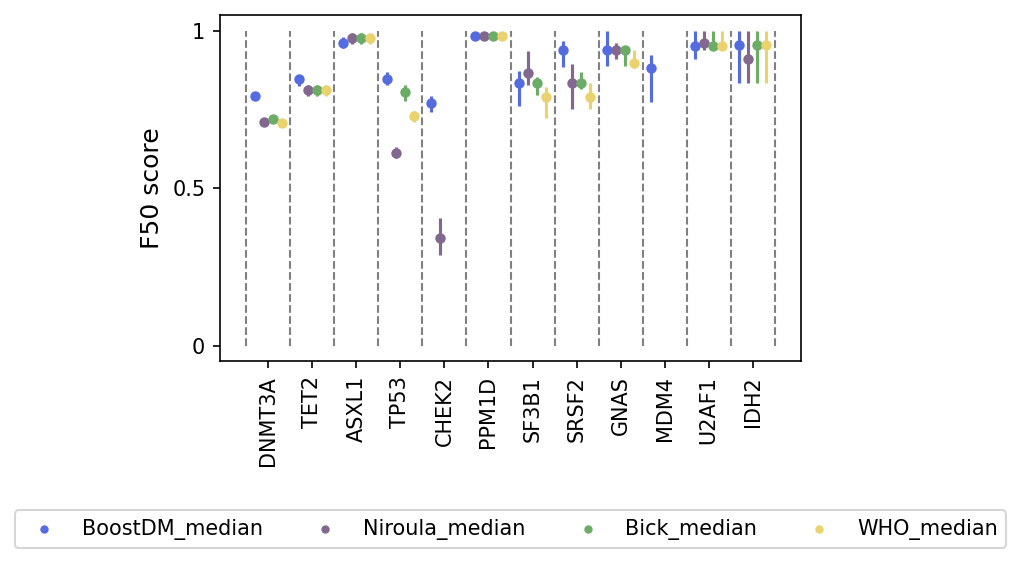

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame containing the data

fig, ax = plt.subplots(figsize=(5, 3))
colors = {'BoostDM': '#556CE0', 'Niroula': '#82678E', 'Bick': '#6DAC67', 'WHO': '#EAD36E'}

sns.stripplot(data=df, x="Gene", y="Accuracy", hue="Method", dodge=True,
              palette=['#556CE0', '#82678E', '#6DAC67', '#EAD36E'])

ax.set_ylabel('F50 score', fontsize=12)
ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels(['0', '0.5', '1'])
ax.set_xlabel('')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=4, markerscale=0.5)


for x in range(-1, len(df['Gene'].unique())):
    plt.plot([x + 0.5, x + 0.5], [0, df['Gene'].max()], c='grey', linestyle='dashed', linewidth=1)

#Add error bar BoostDM
data_Q = Fbeta_12genes[['Gene', 'BoostDM_median', 'BoostDM_q1', 'BoostDM_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.BoostDM_median-row.BoostDM_q1], [row.BoostDM_q3-row.BoostDM_median]]
    plt.errorbar(idx-0.3,row.BoostDM_median, yerr=ci, fmt=' ', ecolor = colors['BoostDM'])

#Add error bar Niroula
data_Q = Fbeta_12genes[['Gene', 'Niroula_median', 'Niroula_q1', 'Niroula_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.Niroula_median-row.Niroula_q1], [row.Niroula_q3-row.Niroula_median]]
    plt.errorbar(idx-0.1,row.Niroula_median, yerr=ci, fmt=' ', ecolor = colors['Niroula'])

#Add error bar Bick
data_Q = Fbeta_12genes[['Gene', 'Bick_median', 'Bick_q1', 'Bick_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.Bick_median-row.Bick_q1], [row.Bick_q3-row.Bick_median]]
    plt.errorbar(idx+0.1,row.Bick_median, yerr=ci, fmt=' ', ecolor = colors['Bick'])

#Add error bar WHO
data_Q = Fbeta_12genes[['Gene', 'WHO_median', 'WHO_q1', 'WHO_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.WHO_median-row.WHO_q1], [row.WHO_q3-row.WHO_median]]
    plt.errorbar(idx+0.3,row.WHO_median, yerr=ci, fmt=' ', ecolor = colors['WHO'])

plt.show()

# Include percentils

In [18]:
### Validation with 10 genes (excluding MDM4 & CHEK2)
from tqdm import tqdm


### Preparation
predictions_dir = '../../Paper_data/BoostDM-CH/prediction/'
results_stat = []
# allgenes_crossval_harv = DNMT3A_crossval_harv[0:0] # create empty dataframe
allgenes_crossval_harv = pd.DataFrame(columns=['gene', 'chr', 'pos', 'alt', 'aachange', 'CLUSTL_SCORE', 'CLUSTL_cat_1',
       'HotMaps_cat_1', 'smRegions_cat_1', 'PhyloP', 'nmd', 'Acetylation',
       'Methylation', 'Phosphorylation', 'Regulatory_Site', 'Ubiquitination',
       'csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing',
       'csqn_type_synonymous', 'role_Act', 'role_LoF', 'ref', 'driver',
       'boostDM_score', 'iteration', 'boostDM_predic', 'Prot_pos', 'Niroula',
       'Bick', 'CNIC', 'WHO'])


genes10 = ['ASXL1', 'DNMT3A', 'GNAS', 'IDH2', 'PPM1D', 'SF3B1', 'SRSF2', 'TET2', 'TP53', 'U2AF1']

### Calculate all statistics
for statistic in tqdm(['Fscore50', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']):    
    ### Analysis
    for i, gene in enumerate(genes10):
        ### Open file crossvalidation
        file_path = '../../Paper_data/BoostDM-CH/Results_crossvalidation_50_iterations/' + gene + '_crossvalidation_50iterations_V2.txt'
        gene_crossval = pd.read_csv(file_path, sep='\t', index_col=0)
        gene_crossval = gene_crossval.drop('boostDM_score', axis=1)

        ### Merge with boostDM prediction output to have the annotation of protein position
        # Get DNMT3A prediction
        gene_model = pd.read_csv(predictions_dir + gene + '.CH.prediction.tsv.gz', sep='\t')
        # Merge
        gene_crossval_info = pd.merge(gene_model[['gene','chr', 'pos', 'alt', 'aachange', 'boostDM_score']],
                                      gene_crossval,
                                      on=['chr', 'pos', 'alt'], how='right')
       
        ### Calculate boostDM prediction 0/1
        gene_crossval_info['boostDM_predic'] = gene_crossval_info['boostDM_score'].apply(lambda x: 1 if x>0.5 else 0)
        
        # Eliminate intronic/splicing rows
        gene_crossval_info = gene_crossval_info[gene_crossval_info['aachange'].notna()].reset_index(drop=True)

        # Create dataframe for the predictions
        gene_crossval_harv = gene_crossval_info
        gene_crossval_harv['row'] = gene_crossval_harv.index        
        
        ### Get predictions from Harvard models (Niroula/Bick) and add to dataframe
        # Niroula
        try:
            niroula_positive = niroula_CH(gene_crossval_info, gene)
            in_niroula = sorted(niroula_positive.index.to_list())
            gene_crossval_harv['Niroula'] = gene_crossval_harv['row'].apply(lambda x: 1 if x in in_niroula else 0)
        except:
            print(gene + ': problem Niroula')
            gene_crossval_harv['Niroula'] = ''
        
        # Bick
        try:
            bick_positive = bick_CH(gene_crossval_info, gene)
            in_bick = sorted(bick_positive.index.to_list())
            gene_crossval_harv['Bick'] = gene_crossval_harv['row'].apply(lambda x: 1 if x in in_bick else 0)
        except:
            print(gene + ': problem Bick')
            gene_crossval_harv['Bick'] = ''
        
        # CNIC
        try:
            CNIC_positive = CNIC_CH(gene_crossval_info, gene)
            in_CNIC = sorted(CNIC_positive.index.to_list())
            gene_crossval_harv['CNIC'] = gene_crossval_harv['row'].apply(lambda x: 1 if x in in_CNIC else 0)
        except:
            print(gene + ': problem CNIC')
            gene_crossval_harv['CNIC'] = ''
        
        if (len(in_niroula) == 0) & (len(in_bick) == 0) & (len(in_CNIC) == 0):
            continue
        
        allgenes_crossval_harv = pd.concat([allgenes_crossval_harv, gene_crossval_harv])

        # WHO
        try:
            WHO_positive = WHO_CH(gene_crossval_info, gene)
            in_WHO = sorted(WHO_positive.index.to_list())
            gene_crossval_harv['WHO'] = gene_crossval_harv['row'].apply(lambda x: 1 if x in in_WHO else 0)
        except:
            print(gene + ': problem WHO')
            gene_crossval_harv['WHO'] = ''
        
        if (len(in_niroula) == 0) & (len(in_bick) == 0) & (len(in_WHO) == 0):
            continue
        
        allgenes_crossval_harv = pd.concat([allgenes_crossval_harv, gene_crossval_harv])

    statistics = [statistic]
    for method in tqdm(['boostDM_predic', 'Niroula', 'Bick', 'CNIC', 'WHO']):
            statistics.append(quality_statistic(allgenes_crossval_harv, method, statistic=statistic))
            statistics.append(mean_i(allgenes_crossval_harv, method, statistic))
            statistics.append(median_i(allgenes_crossval_harv, method, statistic))
            #statistics.append(std_error_i(allgenes_crossval_harv, method, statistic))
            statistics.append(Q1_i(allgenes_crossval_harv, method, statistic))
            statistics.append(Q3_i(allgenes_crossval_harv, method, statistic))
    results_stat.append(statistics)
    
results_dataframe = pd.DataFrame(results_stat)
results_dataframe.columns = ['Gene', 'BoostDM', 'BoostDM_mean', 'BoostDM_median', 'BoostDM_q1', 'BoostDM_q3',
                                 'Niroula', 'Niroula_mean', 'Niroula_median', 'Niroula_q1', 'Niroula_q3',
                                 'Bick', 'Bick_mean', 'Bick_median', 'Bick_q1', 'Bick_q3',
                                 'CNIC', 'CNIC_mean', 'CNIC_median', 'CNIC_q1', 'CNIC_q3',
                                 'WHO', 'WHO_mean', 'WHO_median', 'WHO_q1', 'WHO_q3']
results_dataframe

100%|██████████████████████████████████████████████████████████████████| 6/6 [09:48<00:00, 98.04s/it]


,Gene,BoostDM,BoostDM_mean,BoostDM_median,BoostDM_q1,BoostDM_q3,Niroula,Niroula_mean,Niroula_median,Niroula_q1,Niroula_q3,Bick,Bick_mean,Bick_median,Bick_q1,Bick_q3,CNIC,CNIC_mean,CNIC_median,CNIC_q1,CNIC_q3,WHO,WHO_mean,WHO_median,WHO_q1,WHO_q3
0,Fscore50,0.840377,0.840478,0.837402,0.833142,0.848715,0.746468,0.746587,0.746417,0.739050,0.752363,0.795419,0.795453,0.795902,0.790910,0.803111,0.756826,0.756894,0.755249,0.750094,0.766408,0.756188,0.756247,0.756332,0.749398,0.763611
1,F1,0.854857,0.854886,0.854166,0.849923,0.859086,0.810113,0.810164,0.809731,0.804044,0.815098,0.739279,0.739281,0.739053,0.732980,0.743324,0.809872,0.809898,0.809556,0.803943,0.817062,0.815336,0.815352,0.815206,0.809664,0.821064
2,Accuracy,0.858308,0.858302,0.857247,0.853079,0.863019,0.790128,0.790132,0.789671,0.783414,0.796575,0.778807,0.778830,0.779040,0.774814,0.783169,0.795878,0.795875,0.795036,0.789288,0.804259,0.798656,0.798642,0.798467,0.791725,0.806304
3,Precision,0.830993,0.831169,0.828884,0.821400,0.840979,0.709316,0.709486,0.709376,0.700918,0.715259,0.837836,0.837945,0.840946,0.828930,0.846898,0.725162,0.725265,0.723939,0.717184,0.735468,0.721304,0.721397,0.721949,0.713589,0.729298
4,Recall,0.880131,0.880170,0.881275,0.874052,0.885591,0.944303,0.944316,0.944306,0.942103,0.946931,0.661469,0.661536,0.659129,0.653982,0.667458,0.916990,0.917025,0.917856,0.910783,0.922585,0.937561,0.937563,0.938890,0.932861,0.941154
5,NPV,0.885856,0.885924,0.886381,0.880459,0.891648,0.928409,0.928483,0.928294,0.924555,0.930856,0.743495,0.743581,0.741915,0.739684,0.747495,0.901734,0.901825,0.902484,0.894716,0.908574,0.922864,0.922914,0.923610,0.918159,0.928470


In [19]:
columns = ['Gene']+[x for x in results_dataframe.columns.tolist() if x.endswith('_median')]
columns = [x for x in columns if not x.startswith('CNIC')]
reduced_results = results_dataframe.loc[[0,3,4],columns].reset_index(drop=True)
reduced_results

,Gene,BoostDM_median,Niroula_median,Bick_median,WHO_median
0,Fscore50,0.837402,0.746417,0.795902,0.756332
1,Precision,0.828884,0.709376,0.840946,0.721949
2,Recall,0.881275,0.944306,0.659129,0.938890


In [20]:
error_data = results_dataframe.iloc[[0, 3, 4],:].reset_index(drop=True)
error_data

,Gene,BoostDM,BoostDM_mean,BoostDM_median,BoostDM_q1,BoostDM_q3,Niroula,Niroula_mean,Niroula_median,Niroula_q1,Niroula_q3,Bick,Bick_mean,Bick_median,Bick_q1,Bick_q3,CNIC,CNIC_mean,CNIC_median,CNIC_q1,CNIC_q3,WHO,WHO_mean,WHO_median,WHO_q1,WHO_q3
0,Fscore50,0.840377,0.840478,0.837402,0.833142,0.848715,0.746468,0.746587,0.746417,0.739050,0.752363,0.795419,0.795453,0.795902,0.790910,0.803111,0.756826,0.756894,0.755249,0.750094,0.766408,0.756188,0.756247,0.756332,0.749398,0.763611
1,Precision,0.830993,0.831169,0.828884,0.821400,0.840979,0.709316,0.709486,0.709376,0.700918,0.715259,0.837836,0.837945,0.840946,0.828930,0.846898,0.725162,0.725265,0.723939,0.717184,0.735468,0.721304,0.721397,0.721949,0.713589,0.729298
2,Recall,0.880131,0.880170,0.881275,0.874052,0.885591,0.944303,0.944316,0.944306,0.942103,0.946931,0.661469,0.661536,0.659129,0.653982,0.667458,0.916990,0.917025,0.917856,0.910783,0.922585,0.937561,0.937563,0.938890,0.932861,0.941154


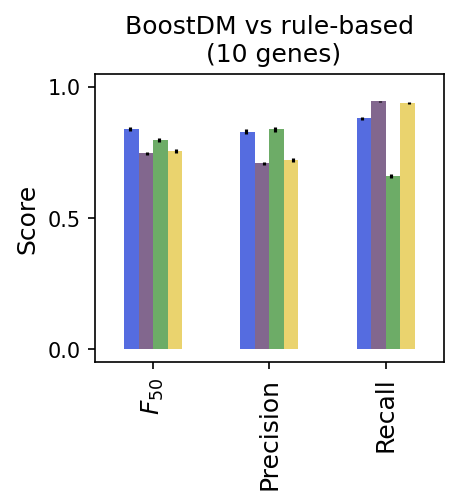

In [21]:
reduced_results.plot.bar(x='Gene', figsize=(3,2.5), color=['#556CE0', '#82678E', '#6DAC67', '#EAD36E'])

#Add error bar BoostDM
data_Q = error_data[['Gene', 'BoostDM_median', 'BoostDM_q1', 'BoostDM_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.BoostDM_median-row.BoostDM_q1], [row.BoostDM_q3-row.BoostDM_median]]
    plt.errorbar(idx-0.2,row.BoostDM_median, yerr=ci, fmt=' ', ecolor = 'k')

#Add error bar Niroula
data_Q = error_data[['Gene', 'Niroula_median', 'Niroula_q1', 'Niroula_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.Niroula_median-row.Niroula_q1], [row.Niroula_q3-row.Niroula_median]]
    plt.errorbar(idx-0.05,row.Niroula_median, yerr=ci, fmt=' ', ecolor = 'k')

#Add error bar Bick
data_Q = error_data[['Gene', 'Bick_median', 'Bick_q1', 'Bick_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.Bick_median-row.Bick_q1], [row.Bick_q3-row.Bick_median]]
    plt.errorbar(idx+0.05,row.Bick_median, yerr=ci, fmt=' ', ecolor = 'k')

#Add error bar WHO
data_Q = error_data[['Gene', 'WHO_median', 'WHO_q1', 'WHO_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.WHO_median-row.WHO_q1], [row.WHO_q3-row.WHO_median]]
    plt.errorbar(idx+0.2,row.WHO_median, yerr=ci, fmt=' ', ecolor = 'k')
    
plt.title('BoostDM vs rule-based\n (10 genes)', size=12)
plt.ylabel('Score', size=12)
plt.xticks(size=12)
plt.xlabel('')
# plt.yticks(np.arange(0, 1, 0.5))
# plt.ylim(-0.1, 1.1)
plt.xticks(np.arange(3), [r"$F_{50}$", 'Precision', 'Recall'], size=12)
plt.yticks(np.arange(0, 2, 0.5))
plt.ylim(-0.05, 1.05)
plt.legend().remove()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.show()

In [23]:
columns = ['Gene']+[x for x in results_dataframe.columns if x.endswith(('median', 'q1', 'q3'))]
cross_validation = results_dataframe.loc[0:0,columns]
cross_validation['Gene'] = 'TCGA + HMF + MSKCC\n (10 genes)'
cross_validation

,Gene,BoostDM_median,BoostDM_q1,BoostDM_q3,Niroula_median,Niroula_q1,Niroula_q3,Bick_median,Bick_q1,Bick_q3,CNIC_median,CNIC_q1,CNIC_q3,WHO_median,WHO_q1,WHO_q3
0,TCGA + HMF + MSKCC\n (10 genes),0.837402,0.833142,0.848715,0.746417,0.73905,0.752363,0.795902,0.79091,0.803111,0.755249,0.750094,0.766408,0.756332,0.749398,0.763611


# Gao exclusive

In [24]:
columns = ['Gene']+[x for x in results_dataframe.columns if x.endswith(('median', 'q1', 'q3'))]
columns

['Gene',
 'BoostDM_median',
 'BoostDM_q1',
 'BoostDM_q3',
 'Niroula_median',
 'Niroula_q1',
 'Niroula_q3',
 'Bick_median',
 'Bick_q1',
 'Bick_q3',
 'CNIC_median',
 'CNIC_q1',
 'CNIC_q3',
 'WHO_median',
 'WHO_q1',
 'WHO_q3']

In [25]:
### Open Gao et al NatCom 2021 (MSKCC) - Open Bolton et al NatGen 2020 (MSKCC)

Gao_Exclusive = pd.read_csv("Other_cohorts/Gao_exclusive_crossvalidation.csv", sep='\t')
columns = ['Statistic']+[x for x in Gao_Exclusive.columns if x.endswith(('median', 'q1', 'q3'))]
Gao_Exclusive = Gao_Exclusive.loc[0:0,columns]
Gao_Exclusive=Gao_Exclusive.rename(columns = {'Statistic':'Gene'})
Gao_Exclusive['Gene'] = 'Uncommon CH mutations\n (6 genes)'
Gao_Exclusive

,Gene,BoostDM_median,BoostDM_q1,BoostDM_q3,Niroula_median,Niroula_q1,Niroula_q3,Bick_median,Bick_q1,Bick_q3,CNIC_median,CNIC_q1,CNIC_q3,WHO_median,WHO_q1,WHO_q3
0,Uncommon CH mutations\n (6 genes),0.792219,0.78066,0.804566,0.742845,0.734193,0.751704,0.746973,0.737056,0.756131,0.739051,0.732369,0.751044,0.75133,0.741146,0.759409


In [26]:
### Open Gao et al NatCom 2021 (MSKCC) - Open Bolton et al NatGen 2020 (MSKCC)

Japanese = pd.read_csv("Other_cohorts/Japanese_crossvalidation.csv", sep='\t')
columns = ['Statistic']+[x for x in Japanese.columns if x.endswith(('median', 'q1', 'q3'))]
Japanese = Japanese.loc[0:0,columns]
Japanese=Japanese.rename(columns = {'Statistic':'Gene'})
Japanese['Gene'] = 'Japanese Biobank\n (9 genes)'
Japanese

,Gene,BoostDM_median,BoostDM_q1,BoostDM_q3,Niroula_median,Niroula_q1,Niroula_q3,Bick_median,Bick_q1,Bick_q3,CNIC_median,CNIC_q1,CNIC_q3,WHO_median,WHO_q1,WHO_q3
0,Japanese Biobank\n (9 genes),0.80382,0.798138,0.808592,0.755295,0.750069,0.757618,0.786394,0.782669,0.790628,0.754117,0.750647,0.759383,0.76087,0.756757,0.764588


In [27]:
cross_validation_all = pd.concat([cross_validation, Gao_Exclusive, Japanese]).reset_index(drop=True)
cross_validation_all

,Gene,BoostDM_median,BoostDM_q1,BoostDM_q3,Niroula_median,Niroula_q1,Niroula_q3,Bick_median,Bick_q1,Bick_q3,CNIC_median,CNIC_q1,CNIC_q3,WHO_median,WHO_q1,WHO_q3
0,TCGA + HMF + MSKCC\n (10 genes),0.837402,0.833142,0.848715,0.746417,0.739050,0.752363,0.795902,0.790910,0.803111,0.755249,0.750094,0.766408,0.756332,0.749398,0.763611
1,Uncommon CH mutations\n (6 genes),0.792219,0.780660,0.804566,0.742845,0.734193,0.751704,0.746973,0.737056,0.756131,0.739051,0.732369,0.751044,0.751330,0.741146,0.759409
2,Japanese Biobank\n (9 genes),0.803820,0.798138,0.808592,0.755295,0.750069,0.757618,0.786394,0.782669,0.790628,0.754117,0.750647,0.759383,0.760870,0.756757,0.764588


In [28]:
columns = ['Gene']+[x for x in cross_validation_all.columns.tolist() if x.endswith('_median')]
columns = [x for x in columns if not x.startswith('CNIC')]
reduced_results = cross_validation_all.loc[:,columns].reset_index(drop=True)
reduced_results

,Gene,BoostDM_median,Niroula_median,Bick_median,WHO_median
0,TCGA + HMF + MSKCC\n (10 genes),0.837402,0.746417,0.795902,0.756332
1,Uncommon CH mutations\n (6 genes),0.792219,0.742845,0.746973,0.751330
2,Japanese Biobank\n (9 genes),0.803820,0.755295,0.786394,0.760870


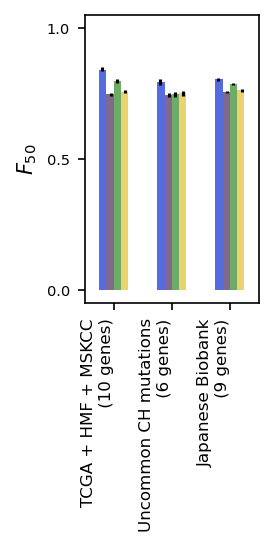

In [29]:
reduced_results.plot.bar(x='Gene', figsize=(1.5,2.5), color=['#556CE0', '#82678E', '#6DAC67', '#EAD36E'])

#Add error bar BoostDM
data_Q = cross_validation_all[['Gene', 'BoostDM_median', 'BoostDM_q1', 'BoostDM_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.BoostDM_median-row.BoostDM_q1], [row.BoostDM_q3-row.BoostDM_median]]
    plt.errorbar(idx-0.2,row.BoostDM_median, yerr=ci, fmt=' ', ecolor = 'k')

#Add error bar Niroula
data_Q = cross_validation_all[['Gene', 'Niroula_median', 'Niroula_q1', 'Niroula_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.Niroula_median-row.Niroula_q1], [row.Niroula_q3-row.Niroula_median]]
    plt.errorbar(idx-0.05,row.Niroula_median, yerr=ci, fmt=' ', ecolor = 'k')

#Add error bar Bick
data_Q = cross_validation_all[['Gene', 'Bick_median', 'Bick_q1', 'Bick_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.Bick_median-row.Bick_q1], [row.Bick_q3-row.Bick_median]]
    plt.errorbar(idx+0.05,row.Bick_median, yerr=ci, fmt=' ', ecolor = 'k')

#Add error bar WHO
data_Q = cross_validation_all[['Gene', 'WHO_median', 'WHO_q1', 'WHO_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.WHO_median-row.WHO_q1], [row.WHO_q3-row.WHO_median]]
    plt.errorbar(idx+0.2,row.WHO_median, yerr=ci, fmt=' ', ecolor = 'k')
    
plt.ylabel(r"$F_{50}$", size=10)
plt.xticks(size=8, rotation=90, horizontalalignment='right', verticalalignment='top')
plt.yticks(size=7)
plt.xlabel('')
plt.yticks(np.arange(0, 2, 0.5))
plt.ylim(-0.05, 1.05)
plt.legend().remove()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.show()